In [125]:
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

In [126]:
# Connect to the databases
deliveroo_conn = sqlite3.connect("./databases/deliveroo.db")
takeaway_conn = sqlite3.connect("./databases/takeaway.db")
ubereats_conn = sqlite3.connect("./databases/ubereats.db")
# Create cursors
deliveroo = conn1.cursor()
takeaway = conn2.cursor()
ubereats = conn3.cursor()

In [127]:
codes_flanders = [code for code in range(2000, 3000)] + [code for code in range(9000, 10000)]\
                        + [code for code in range(1500, 2000)] + [code for code in range(3000, 4000)]\
                        + [code for code in range(8000, 9000)]

In [128]:
geographic_df = gpd.read_file('./geodata/postaldistricts.shp')
geographic_df.rename(columns={'nouveau_PO': 'PostalCode'}, inplace=True)
geographic_df['PostalCode'] = geographic_df['PostalCode'].astype('int64')
geographic_df.head()

,Join_Count,PostalCode,FREQUENCY,CP_speciau,Shape_Leng,Shape_Area,geometry
0,1,5012,2,1,977.714223,3.838034e+04,"POLYGON Z ((685645.15 628039.549 0, 685697.547..."
1,1,5012,2,1,123.021423,8.601421e+02,"POLYGON Z ((685789.894 628275.337 0, 685781.72..."
2,1,5589,1,1,1197.205234,6.306885e+04,"POLYGON Z ((713828.21 594567.55 0, 714154.48 5..."
3,1094,5560,2,0,54736.127330,5.406061e+07,"POLYGON Z ((691357.659 601352.353 0, 691375.65..."
4,1357,5370,1,0,74754.001683,8.154068e+07,"POLYGON Z ((710598.535 623267.261 0, 711187.63..."


## 2. What is the distribution of restaurants per location?

<Axes: >

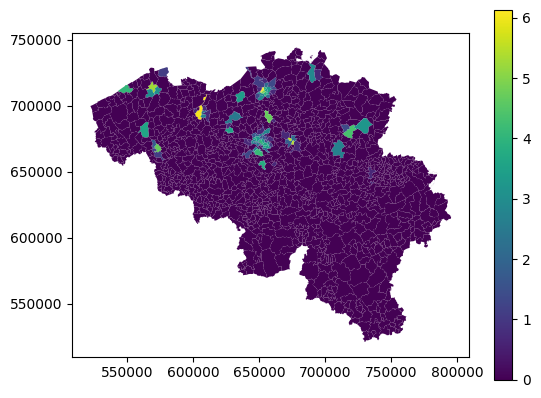

In [129]:
query = """
SELECT r.postal_code AS PostalCode, COUNT(r.id) AS RestaurantCount
FROM restaurants r
GROUP BY r.postal_code
"""

location_dist = pd.read_sql_query(query, deliveroo_conn)
location_dist['PostalCode'] = pd.to_numeric(location_dist['PostalCode'], errors='coerce')
dist = geographic_df.merge(location_dist, on='PostalCode', how='left').fillna(0)
dist['RestaurantCountLog'] = dist['RestaurantCount'].apply(lambda x: np.log1p(x))
dist.plot('RestaurantCountLog', legend=True)

<Axes: >

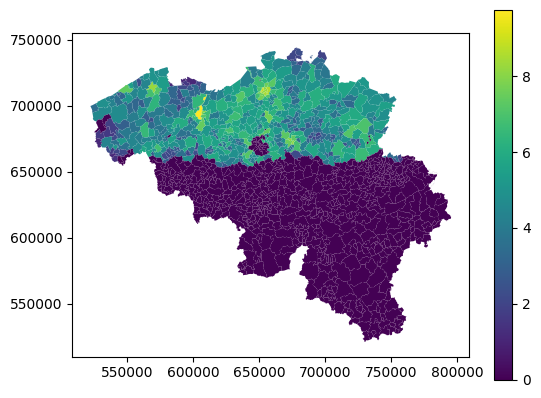

In [130]:
query = """
SELECT l.postalCode AS PostalCode, COUNT(r.restaurant_id) AS RestaurantCount
FROM restaurants r
JOIN locations_to_restaurants ltr ON r.primarySlug = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.ID
GROUP BY l.postalCode
"""

location_dist = pd.read_sql_query(query, takeaway_conn)
dist = geographic_df.merge(location_dist, on='PostalCode', how='left').fillna(0)
dist['RestaurantCountLog'] = dist['RestaurantCount'].apply(lambda x: np.log1p(x))
dist.plot('RestaurantCountLog', legend=True)

(440, 4)


<Axes: >

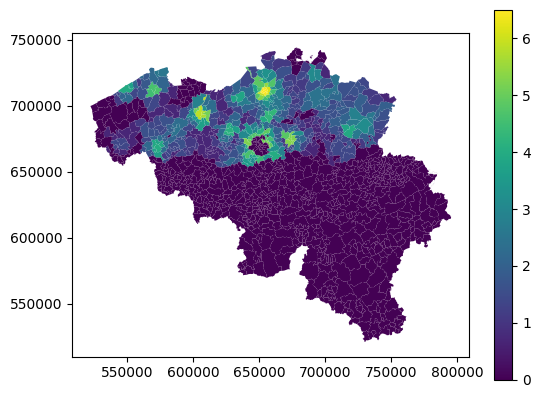

In [131]:
query = """
SELECT DISTINCT r.title, l.name, l.region AS PostalCode, COUNT(DISTINCT r.title) AS RestaurantCount
FROM restaurants r
JOIN locations_to_restaurants ltr ON r.id = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.id
GROUP BY PostalCode
"""

location_dist = pd.read_sql_query(query, ubereats_conn)
print(location_dist.shape)
location_dist['PostalCode'] = pd.to_numeric(location_dist['PostalCode'], errors='coerce')
dist = geographic_df.merge(location_dist, on='PostalCode', how='left').fillna(0)
dist['RestaurantCountLog'] = dist['RestaurantCount'].apply(lambda x: np.log1p(x))
dist.plot('RestaurantCountLog', legend=True)

# 4. Map locations offering kapsalons and their average price.

<Axes: >

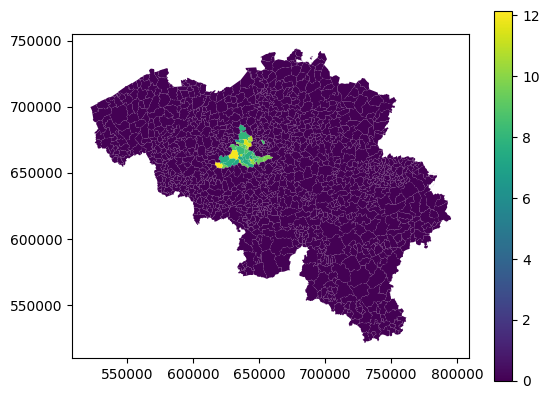

In [150]:
query = """
SELECT r.postal_code AS PostalCode, c.name, AVG(mi.price) AS price
FROM restaurants r
JOIN categories c ON r.id = c.restaurant_id
JOIN menu_items mi ON c.categorie_id = mi.categorie_id
WHERE c.name LIKE '%kapsalon%'
GROUP BY r.postal_code
"""

data = pd.read_sql_query(query, deliveroo_conn)
data['PostalCode'] = pd.to_numeric(location_dist['PostalCode'], errors='coerce')
dist = geographic_df.merge(data, on='PostalCode', how='left').fillna(0)
dist.plot('price', legend=True)

In [136]:
query = """
SELECT c.name AS category, AVG(m.price) AS price, l.postalCode AS PostalCode
FROM restaurants r
JOIN menuItems m ON r.primarySlug = m.primarySlug
JOIN categories c ON r.primarySlug = c.restaurant_id
JOIN locations_to_restaurants ltr ON r.primarySlug = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.ID
WHERE c.name LIKE '%kapsalon%'
GROUP BY PostalCode
ORDER BY price DESC
"""

data = pd.read_sql_query(query, takeaway_conn)
data.head()

,name,city,category,name,price,PostalCode
0,Pizza Taliano,Zwevegem,Kapsalon,Pizza Bolognaise,14.814198,8587
1,Dunya Kebab,Westerlo,Kapsalon,Fanta Cassis,13.668240,2980
2,Dunya Kebab,Westerlo,Kapsalon,Fanta Cassis,13.393355,2242
3,Pizza Roma,Ieper,Kapsalon,Capricciosa,13.298268,8958
4,Pizza Roma,Ieper,Kapsalon,Capricciosa,13.298268,8957


<Axes: >

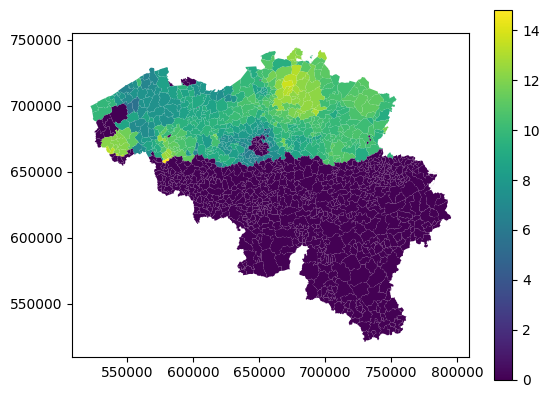

In [140]:
dist = geographic_df.merge(data, on='PostalCode', how='left').fillna(0)
#dist['price'] = dist['price'].apply(lambda x: np.log1p(x))
dist.plot('price', legend=True)

<Axes: >

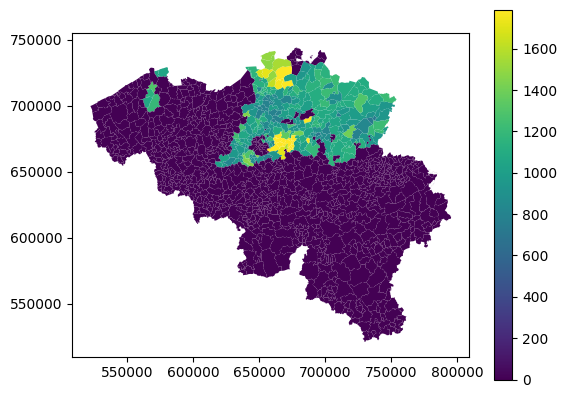

In [167]:
query = """
SELECT r.title, AVG(mi.price) AS price, l.region AS PostalCode, rtc.category, mi.name
FROM restaurants r
JOIN menu_items mi ON r.id = mi.restaurant_id
JOIN locations_to_restaurants ltr ON r.id = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.id
JOIN restaurant_to_categories rtc ON r.id = rtc.restaurant_id
WHERE mi.name LIKE '%kapsalon%'
GROUP BY PostalCode
"""

data = pd.read_sql_query(query, ubereats_conn)
data.head()
data['PostalCode'] = pd.to_numeric(location_dist['PostalCode'], errors='coerce')
dist = geographic_df.merge(data, on='PostalCode', how='left').fillna(0)
dist.plot('price', legend=True)

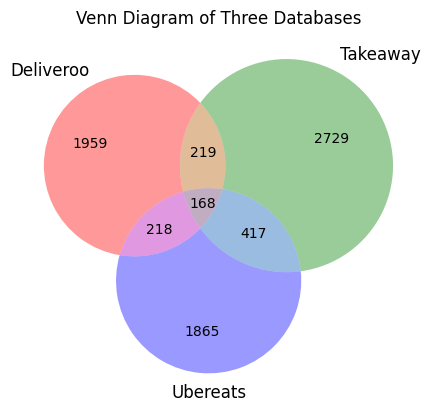

In [179]:
# Query unique IDs from each database
deliveroo.execute("SELECT DISTINCT name FROM restaurants")
ids1 = set(row[0] for row in deliveroo.fetchall())
takeaway.execute("SELECT DISTINCT name FROM restaurants")
ids2 = set(row[0] for row in takeaway.fetchall())
ubereats.execute("""
SELECT DISTINCT r.title 
FROM restaurants r
""")
ids3 = set(row[0] for row in ubereats.fetchall())

# Unique to each database
only_in_1 = ids1 - ids2 - ids3
only_in_2 = ids2 - ids1 - ids3
only_in_3 = ids3 - ids1 - ids2
# Pairwise overlaps
in_1_and_2 = (ids1 & ids2) - ids3
in_1_and_3 = (ids1 & ids3) - ids2
in_2_and_3 = (ids2 & ids3) - ids1
# Overlap in all three
in_all = ids1 & ids2 & ids3

# Sizes for the Venn diagram
venn = venn3(
    subsets=(
        len(only_in_1),      # Unique to DB1
        len(only_in_2),      # Unique to DB2
        len(in_1_and_2),     # Shared by DB1 and DB2
        len(only_in_3),      # Unique to DB3
        len(in_1_and_3),     # Shared by DB1 and DB3
        len(in_2_and_3),     # Shared by DB2 and DB3
        len(in_all)          # Shared by all three
    ),
    set_labels=("Deliveroo", "Takeaway", "Ubereats")
)

# Customize the plot
plt.title("Venn Diagram of Three Databases")
plt.show()

## 8. Which restaurants have the best price-to-rating ratio?

In [177]:
query = """
SELECT r.name, (AVG(r.rating) / SUM(mi.price)) AS ratio
FROM restaurants r
JOIN categories c ON r.id = c.restaurant_id
JOIN menu_items mi ON c.categorie_id = mi.categorie_id
GROUP BY r.name
ORDER BY ratio DESC
"""

data =  pd.read_sql_query(query, deliveroo_conn)
data.head()

,name,ratio
0,Carrefour Express Voskenslaan,0.249680
1,Stadsbrouwerij De Koninck,0.242105
2,#Kitchens,0.232432
3,Café Pistolet,0.219048
4,Bubble Land,0.186667


In [176]:
query = """
SELECT r.name, (AVG(r.ratings) / SUM(mi.price)) AS ratio
FROM restaurants r
JOIN menuItems mi ON r.primarySlug = mi.primarySlug
GROUP BY r.name
ORDER BY ratio DESC
"""

data =  pd.read_sql_query(query, takeaway_conn)
data.head()

,name,ratio
0,El Bocadillos,0.350000
1,Pâtisserie Doce Tentação,0.238095
2,Hard Rock Cafe,0.183529
3,Rumah Jawa,0.177778
4,Au Petit En Cas (chez Lucie),0.157692


In [178]:
query = """
SELECT r.title, (AVG(r.rating__rating_value) / SUM(mi.price)) AS ratio
FROM restaurants r
JOIN menu_items mi ON r.id = mi.restaurant_id
GROUP BY r.title
ORDER BY ratio DESC
"""

data =  pd.read_sql_query(query, ubereats_conn)
data.head()

,title,ratio
0,So Sushi Dilbeek,0.015000
1,RUBA - Healthy Fresh Food,0.013143
2,O'Tacos - Mechelen,0.011429
3,PokÃ© House - Antwerpen,0.009250
4,Belchicken - Basilix,0.008039


## 9. Where are the delivery ‘dead zones’—areas with minimal restaurant coverage?